# Sentiment Polarity Prediction Introduction

This notebook experiments with various implementations of document-level sentiment analysis for movie reviews. The goal of the designed sentiment analysis model is to classify a movie review as either positive or negative.

Code for a classification system which uses Multinomial Naive Bayes was provided as a baseline model for this assignment. I took the code for this model, refactored it, expanded it and have implemented a more stream lined version of this code. I have also incorporated experimentation with different learning algorithms, model parameters and feature sets to improve on the accuracy scored by the baseline model.

All of the models in this notebook are trained on the movie review polarity data of Pang and Lee 2004 [A Sentimental Education: Sentiment Analysis Using Subjectivity Summarization Based on Minimum Cuts](https://www.aclweb.org/anthology/P04-1035/). The dataset used in this paper is  available at http://www.cs.cornell.edu/People/pabo/movie-review-data (section "Sentiment polarity datasets") and contains 1000 positive and 1000 negative reviews, with each review being tokenised, sentence-split (one sentence per line) and lowercased.

In this dataset, each review has been assigned to 1 of 10 cross-validation folds by the authors. In order to compare our results with the published results, this is the setup I follow in this notebook. The models are evaluated and compared using an average of the 10-fold cross-validation accuracy scores.

During this process, no special treatment is given to rare or unknown words. Unknown words in the test data are skipped.

# -----------------------------------------------------------------------------------------------------------------

# Setup

### Packages neded to install

In order to be able to re-implement this work, there are a number of packages you will need to install. The commands for these are as follows:
- conda install numpy
- conda install pandas
- conda install tabulate
- conda install matplotlib
- conda install selenium
- conda install tqdm
- conda install scikit-learn (version > 0.24.0)
- conda install spacy

### Import packages

In [1]:
# general packages
import os
import time
import pandas as pd
from tqdm.auto import tqdm
import numpy as np

In [2]:
# models needed for modelling
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

### Import the classes and functions from the '.py' file

Instead of having this notebook full of different functions with different applications, I decided to extract these from the notebook and to put them into a '.py' file. I could then read these functions in from the '.py' file without any problem which would enable me to keep this notebook compact and streamlined. The functions themselves are then easily accessible and readable from the '.py' file.

In [3]:
%load_ext autoreload
%autoreload 1
%aimport Sentiment_classification_functions

import Sentiment_classification_functions as scf

### Define the location of the chromedriver

In this code, I make use of a chromedriver to download the data from the internet. This is only done if the data is not already in your local folder. If you have cloned my original repo then the data will already be in the right place - in the 'Data' folder.

In [4]:
chromedriver_location = 'chromedriver.exe'

### Define the location of the data folder

In [5]:
data_directory = "Data"

# -----------------------------------------------------------------------------------------------------------------

# Load in the data

In starting this assignment, the first thing that needed to be done was I needed to go through the initially provided code and gain an understanding of it. When I did this, I realised how unnecessarily long and complex it was. My first job was to  simplify this code down to make it more understandable.

The first job in this was to remove the classes that were used in the original. I felt that all of the classes for reading in the data could be simplified down into one function called *'load_data'*. This function encapsulated the same functionality as the classes in the original code, which is:
1. Read in all the files in the data
    - If you have the data already downloaded then this data will be read in.
    - If you don't have the data already downloaded, the data will be downloaded from the web, put into the specified data folder, and then read in.
2. Turn this data into a map of cross validation folds and class labels to their associated documents

I found this more simplistic approach worked well and condensed a lot of code and classes down into one function. The resulting output is a dictionary in the following format:

    {(cross validation fold 1, 'pos'): [[list of sentences in doc1], [list of sentences in doc2], ...],
     (cross validation fold 1, 'neg'): [[list of sentences in doc1], [list of sentences in doc2], ...],
     ............................................................................................................
     (cross validation fold 10, 'pos'): [[list of sentences in doc1], [list of sentences in doc2], ...],
     (cross validation fold 10, 'neg'): [[list of sentences in doc1], [list of sentences in doc2], ...],
    }
This dictionary has two enteries for each cross validation fold, one for the positive documents and one for the negative documents. Each value in the dictionary then contains a list of documents associated with that cross validation fold and class label pair. Each document in this list is made up of a list of sentences with each sentence, in turn, being made up of a list of tokens.

### Load in the original data

This data file contains the original data that was used in the provided baseline model. While I wanted to change the input data to experiment with different features, I did not change this file for the purpose of being able to re-create the exact same results as the baseline model. I will instead use this original file to create the features I am looking for.

In [6]:
original_data_dict = scf.load_data(data_directory, chromedriver_location)

##### Preview the documents in this data

We can have a look at a preview of each document that falls under a specified fold & labal pair. The below preview table details the number of documents associated with the specified fold & label pair, the number of sentences each of these documents has and then the first *'n'* characters in this document. This *'n'* value can be changed to display any amount of characters desired.

In [7]:
for label in ['pos', 'neg']:
    print('\n====', label, '====')
    docs_preview = scf.preview_docs_with_fold_label_pair(original_data_dict, fold=0, label=label, max_length=50, sep=" ")
    print(docs_preview.to_markdown())


==== pos ====
|    |   doc_num |   sentences | start_of_first_sentence                            |
|---:|----------:|------------:|:---------------------------------------------------|
|  0 |         0 |          25 | films adapted from comic books have had plenty of  |
|  1 |         1 |          39 | every now and then a movie comes along from a      |
|  2 |         2 |          19 | you've got mail works alot better than it deserves |
|  3 |         3 |          42 | " jaws " is a rare film that grabs your attention  |
|  4 |         4 |          25 | moviemaking is a lot like being the general        |
|  5 |         5 |          34 | on june 30 , 1960 , a self-taught , idealistic ,   |
|  6 |         6 |          31 | apparently , director tony kaye had a major battle |
|  7 |         7 |          32 | one of my colleagues was surprised when i told her |
|  8 |         8 |          14 | after bloody clashes and independence won ,        |
|  9 |         9 |          18 | the am

|    |   doc_num |   sentences | start_of_first_sentence                            |
|---:|----------:|------------:|:---------------------------------------------------|
|  0 |         0 |          35 | plot : two teen couples go to a church party ,     |
|  1 |         1 |          13 | the happy bastard's quick movie review damn that   |
|  2 |         2 |          23 | it is movies like these that make a jaded movie    |
|  3 |         3 |          19 | " quest for camelot " is warner bros . ' first     |
|  4 |         4 |          37 | synopsis : a mentally unstable man undergoing      |
|  5 |         5 |          35 | capsule : in 2176 on the planet mars police taking |
|  6 |         6 |          27 | so ask yourself what " 8mm " ( " eight millimeter  |
|  7 |         7 |          27 | that's exactly how long the movie felt to me .     |
|  8 |         8 |          33 | call it a road trip for the walking wounded .      |
|  9 |         9 |          49 | plot : a young french

### Create a lemmatised version of this data

Once I had the original data loaded, I could then work on using this to create different versions of this data that I could experiment with to try to improve the accuracy of the models. The first of these different versions I created was a lemmatised version of the data as I wanted to see whether lemmatising the words would enable me to better predict the class of a document. In this version, the data would be iterated through and each token would be turned to a lemmatised version of itself. This was done with the help of the spacy package and its english language text processor which could easily identify the lemmatised version of each word.

* This creation takes about 4:20 mins

In [8]:
lem_data_dict = scf.lemmatise_the_data(original_data_dict)

  0%|          | 0/20 [00:00<?, ?it/s]

##### Preview the documents in this data

Again we can look at a preview of each document that falls under a specified fold & label pair. Here you can see in the document previews that the words have been changed - plural words have been changed to singular and different verb versions have been changed to their base form.

NOTE: Outside the lemmatisation, there is another slight difference between this data and the original data as the tokaniser used to create this lemmatised version is the native spacy tokaniser. This tokaniser is different to the one used in the original as it turns contractions, like "don't" or "I've" into two tokens ("do n't" & "I 've") as opposed to having these contractions being one word. While I don't think this difference will have a massive effect on the outcome, it is something to note as being different from the original alongside the lemmatisation.

In [9]:
for label in ['pos', 'neg']:
    print('\n====', label, '====')
    docs_preview = scf.preview_docs_with_fold_label_pair(lem_data_dict, fold=0, label=label, max_length=50, sep=" ")
    print(docs_preview.to_markdown())


==== pos ====
|    |   doc_num |   sentences | start_of_first_sentence                            |
|---:|----------:|------------:|:---------------------------------------------------|
|  0 |         0 |          25 | film adapt from comic book have have plenty of     |
|  1 |         1 |          39 | every now and then a movie come along from a       |
|  2 |         2 |          19 | you 've get mail work alot well than it deserve to |
|  3 |         3 |          42 | " jaw " be a rare film that grab your attention    |
|  4 |         4 |          25 | moviemake be a lot like be the general manager of  |
|  5 |         5 |          34 | on june 30 , 1960 , a self - teach , idealistic ,  |
|  6 |         6 |          31 | apparently , director tony kaye have a major       |
|  7 |         7 |          32 | one of my colleague be surprised when I tell she I |
|  8 |         8 |          14 | after bloody clash and independence win , lumumba  |
|  9 |         9 |          18 | the am

### Create a version of this data with negation handled in it

The next version of the original data that I wanted to create from the original data was one where negation was handled. This version would then be experimented with to see whether handling negation has an effect on the resulting accuracy scores.

While there are a number of ways negation can be handled, in this function, the negation is handled in a simple manner. Here if a negative word appears, like "*not*", "*no*" or a word ending in "*n't*", then the words that follow this word up until the next punctuation mark are changed to add "*NOT_*" as a prefix.

Eg. "The man didn't know how to speak, but he was fine." --> "The man didn't NOT_know NOT_how NOT_to NOT_speak, but he was fine."

In [10]:
negated_data_dict = scf.handle_negation_in_the_data(original_data_dict)

##### Preview the documents in this data

The above logic is easy to see in the below previews where you can see *'NOT_'* has been added to words appearing after negative words.

NOTE: Unlike in the lemmatised data, the tokens here are the same as that used in the original data and contractions remain as one word.

In [11]:
for label in ['pos', 'neg']:
    print('\n====', label, '====')
    docs_preview = scf.preview_docs_with_fold_label_pair(negated_data_dict, fold=0, label=label, max_length=50, sep=" ")
    print(docs_preview.to_markdown())


==== pos ====
|    |   doc_num |   sentences | start_of_first_sentence                            |
|---:|----------:|------------:|:---------------------------------------------------|
|  0 |         0 |          25 | films adapted from comic books have had plenty of  |
|  1 |         1 |          39 | every now and then a movie comes along from a      |
|  2 |         2 |          19 | you've got mail works alot better than it deserves |
|  3 |         3 |          42 | " jaws " is a rare film that grabs your attention  |
|  4 |         4 |          25 | moviemaking is a lot like being the general        |
|  5 |         5 |          34 | on june 30 , 1960 , a self-taught , idealistic ,   |
|  6 |         6 |          31 | apparently , director tony kaye had a major battle |
|  7 |         7 |          32 | one of my colleagues was surprised when i told her |
|  8 |         8 |          14 | after bloody clashes and independence won ,        |
|  9 |         9 |          18 | the am

|    |   doc_num |   sentences | start_of_first_sentence                            |
|---:|----------:|------------:|:---------------------------------------------------|
|  0 |         0 |          35 | plot : two teen couples go to a church party ,     |
|  1 |         1 |          13 | the happy bastard's quick movie review damn that   |
|  2 |         2 |          23 | it is movies like these that make a jaded movie    |
|  3 |         3 |          19 | " quest for camelot " is warner bros . ' first     |
|  4 |         4 |          37 | synopsis : a mentally unstable man undergoing      |
|  5 |         5 |          35 | capsule : in 2176 on the planet mars police taking |
|  6 |         6 |          27 | so ask yourself what " 8mm " ( " eight millimeter  |
|  7 |         7 |          27 | that's exactly how long the movie felt to me .     |
|  8 |         8 |          33 | call it a road trip for the walking wounded .      |
|  9 |         9 |          49 | plot : a young french

# -----------------------------------------------------------------------------------------------------------------

# Create training-test splits for Cross-Validation

This is where we split these datasets into train and test splits. There are 1000 positive documents and 1000 negative documents and we must split these 2000 documents into 10 different cross validation splits. This gives an 1800-200 train-test split for each of the 10 cross validation folds.

Each dataset created above contains exactly the same number of documents with each document being in the exact same order and having the same sentences within it. As a results, we can garentee that the sentences and documents in each cross validation set are the exact same across all of these datasets. This is important as it makes sure that the data we are testing on and comparing the models with is as close to the exact same as possible and that the only variable between them is the one change made to the dataset (lemmatisation, negation handling, or whatever it may be).

In [12]:
org_train_test_splits = scf.get_train_test_splits(original_data_dict)
lem_train_test_splits = scf.get_train_test_splits(lem_data_dict)
neg_train_test_splits = scf.get_train_test_splits(negated_data_dict)

### Show the splits

We can visualise the number of documents in each cross validation fold. As discussed, this breakdown is the exact same across all datasets.

In [13]:
scf.count_docs_in_train_test_split(org_train_test_splits)

,train_set_size,test_set_size
0,1800,200
1,1800,200
2,1800,200
3,1800,200
4,1800,200
5,1800,200
6,1800,200
7,1800,200
8,1800,200
9,1800,200


# -----------------------------------------------------------------------------------------------------------------

# Run a small scale test

### Choose the model

In [132]:
model = scf.Model(model=MultinomialNB())
#model = scf.Model(model=LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=200))
#model = scf.Model(SGDClassifier())
#model = scf.Model(RandomForestClassifier())
#model = scf.Model(model=SVC())
#model = scf.Model(model=DecisionTreeClassifier())

### Choose the data

In [56]:
#train_test_splits = org_train_test_splits
#train_test_splits = lem_train_test_splits
train_test_splits = neg_train_test_splits

### Measure the model performance using one train-test split

In [137]:
sample_train_data, sample_test_data = train_test_splits[0]
model.train(sample_train_data)
scf.print_first_n_predictions(model, sample_test_data, num_predictions=10, len_preview=50)

Accuracy = 0.825
Confusion_matrix:
 [[84 16]
 [19 81]]


,label,prediction,documents
0,neg,neg,"plot : two teen couples go to a church party ,"
1,neg,neg,the happy bastard's quick movie review damn that
2,neg,neg,it is movies like these that make a jaded movie
3,neg,pos,""" quest for camelot "" is warner bros . ' first"
4,neg,neg,synopsis : a mentally unstable man undergoing
5,neg,neg,capsule : in 2176 on the planet mars police ta...
6,neg,neg,"so ask yourself what "" 8mm "" ( "" eight millimeter"
7,neg,neg,that's exactly how long the movie felt to me .
8,neg,pos,call it a road trip for the walking wounded .
9,neg,neg,plot : a young french boy sees his parents killed


### Measure the model performance Cross-Validating across all train-test splits

In [143]:
model_params = {"full_name": "_", "data_type": "Original", "ngram": "Unigram", "model_name": "Multinomial", "clip_counts": False}

   Fold 1 - 4 seconds --> Accuracy score = 0.825
   Fold 2 - 4 seconds --> Accuracy score = 0.855
   Fold 3 - 4 seconds --> Accuracy score = 0.83
   Fold 4 - 4 seconds --> Accuracy score = 0.86
   Fold 5 - 4 seconds --> Accuracy score = 0.82
   Fold 6 - 4 seconds --> Accuracy score = 0.83
   Fold 7 - 4 seconds --> Accuracy score = 0.845
   Fold 8 - 4 seconds --> Accuracy score = 0.83
   Fold 9 - 4 seconds --> Accuracy score = 0.785
   Fold 10 - 4 seconds --> Accuracy score = 0.865


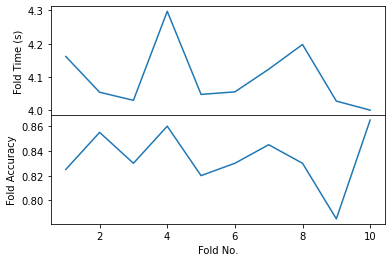

,Data Type,Ngram,Model,Clip Counts,Avg Accuracy,Accuracy Std Dev,Min Accuracy,Max Accuracy,Total Time (s),All Fold Averages
0,Original,Unigram,Multinomial,False,0.8345,0.022187,0.785,0.865,41.26,"[0.825, 0.855, 0.83, 0.86, 0.82, 0.83, 0.845, ..."


In [145]:
scf.evaluate_model(model, model_params, train_test_splits, fold_verbose=True, plot_folds=True)

# -----------------------------------------------------------------------------------------------------------------

# Compare different models

  1) Experimenting with different learning algorithms, e.g. logistic regression, decision trees, support vector machines, etc.
  2) Experimenting with different feature sets, such as:
      a) Handling negation
      b) looking at bigrams and trigrams rather than just words
      c) using sentiment lexicons
      d) performing linguistic analysis of the input (e.g. part-of-speech tagging)

### Define the location where the results of the model evaluation are to be stored

In [31]:
model_eval_results_directory = os.path.join(data_directory, "Model_results")

### Choose the models to use and the parameters to experiment with

Default models
 - sklearn.naive_bayes.MultinomialNB(*, alpha=1.0, fit_prior=True, class_prior=None)
 - sklearn.linear_model.LogisticRegression(penalty='l2', *, dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver='lbfgs', max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)
 - sklearn.linear_model.SGDClassifier(loss='hinge', *, penalty='l2', alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=1000, tol=0.001, shuffle=True, verbose=0, epsilon=0.1, n_jobs=None, random_state=None, learning_rate='optimal', eta0=0.0, power_t=0.5, early_stopping=False, validation_fraction=0.1, n_iter_no_change=5, class_weight=None, warm_start=False, average=False)
 - sklearn.ensemble.RandomForestClassifier(n_estimators=100, *, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)
 - sklearn.svm.SVC(*, C=1.0, kernel='rbf', degree=3, gamma='scale', coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=- 1, decision_function_shape='ovr', break_ties=False, random_state=None)
 - sklearn.tree.DecisionTreeClassifier(*, criterion='gini', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, class_weight=None, ccp_alpha=0.0)

In [42]:
model_dict = {#"Multinomial Naive Bayes":                MultinomialNB(),
              #"Stochastic Gradient Descent Classifier": SGDClassifier(),
              #"Random Forest Classifier":               RandomForestClassifier(),
              #"Decision Tree":                          DecisionTreeClassifier(),
              #"Support Vector Machine":                 SVC(),
              "Logistic Regression":                    LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=500),
             }

data_dict = {"Original":   org_train_test_splits,
             "Lemmatised": lem_train_test_splits,
             "Negated":    neg_train_test_splits,
            }
    
ngram_size_dict = {"Unigram": 1,
                   "Bigram":  2,
                   "Trigram": 3,
                  }

clip_counts_vals = [True, False]

### Iterate through all the combinations of these parameters and define a model for each

In [43]:
models_to_compare = scf.define_models_with_params(model_dict, data_dict, ngram_size_dict, clip_counts_vals)
models_to_compare

| There are a total of 18 models that have been defined through different combinations of these parameters.|


[({'full_name': 'Original Unigram Logistic Regression (ClipCounts=True)',
   'model_name': 'Logistic Regression',
   'data_type': 'Original',
   'ngram': 'Unigram',
   'clip_counts': True},
  <Sentiment_classification_functions.Model at 0x15d40c77190>),
 ({'full_name': 'Original Unigram Logistic Regression (ClipCounts=False)',
   'model_name': 'Logistic Regression',
   'data_type': 'Original',
   'ngram': 'Unigram',
   'clip_counts': False},
  <Sentiment_classification_functions.Model at 0x15d40c77520>),
 ({'full_name': 'Original Bigram Logistic Regression (ClipCounts=True)',
   'model_name': 'Logistic Regression',
   'data_type': 'Original',
   'ngram': 'Bigram',
   'clip_counts': True},
  <Sentiment_classification_functions.Model at 0x15d40c773d0>),
 ({'full_name': 'Original Bigram Logistic Regression (ClipCounts=False)',
   'model_name': 'Logistic Regression',
   'data_type': 'Original',
   'ngram': 'Bigram',
   'clip_counts': False},
  <Sentiment_classification_functions.Model at 0

### Train & test these models and then output them to a CSV

In [ ]:
error_names = []
for model_params, model in tqdm(models_to_compare):
    try:
        print("\n" + model_params["full_name"])
        # evaluate the model
        model_eval_df = scf.evaluate_model(model, model_params, neg_train_test_splits, fold_verbose=True, plot_folds=True)
        # save this models evalutaion scores to a CSV
        model_eval_df.to_csv(os.path.join(model_eval_results_directory, model_params["full_name"]+'.csv'), index=False)
     
    except KeyboardInterrupt:
        break
    except:
        # this is in case of a RAM issue or other - to prevent the run crashing we just skip that model and move on
        error_names.append(model_params)

  0%|          | 0/18 [00:00<?, ?it/s]


Original Unigram Logistic Regression (ClipCounts=True)
   Fold 1 - 25 seconds --> Accuracy score = 0.84
   Fold 2 - 34 seconds --> Accuracy score = 0.855
   Fold 3 - 26 seconds --> Accuracy score = 0.84
   Fold 4

### Manually inspect the evaluation scores

In [23]:
error_names

[]

# -----------------------------------------------------------------------------------------------------------------

In [41]:
order = ["Full Name", "Data Type", "Ngram", "Model", "Clip Counts", "Avg Accuracy", "Accuracy Std Dev", "Min Accuracy", "Max Accuracy", "Total Time (s)", "All Fold Averages"]

folder_with_model_results = os.path.join(data_directory, 'Model_results - Copy')
for file in os.listdir(folder_with_model_results):
    filepath = os.path.join(folder_with_model_results, file)
    model_results = pd.read_csv(filepath).iloc[0]
    
    '''
    # add an ngram column
    if "Clip Counts" not in model_results:
        if "with" in file:
            model_results["Clip Counts"] = True
        else:
            model_results["Clip Counts"] = False
            
    # add an ngram column
    if "Ngram" not in model_results:
        if "Unigram" in file:
            model_results["Ngram"] = "Unigram"
        elif "Bigram" in file:
            model_results["Ngram"] = "Bigram"
        elif "Trigram" in file:
            model_results["Ngram"] = "Trigram"
        
    # add Lemmatisation column
    if "Lemmatisation" not in model_results:
        model_results["Lemmatisation"] = False
        
    full_name = "{} {} {} (ClipCounts={})".format(model_results["Data Type"], model_results["Ngram"], model_results["Model"], model_results["Clip Counts"])
    '''
    
    # create a full name value for each dataframe
    model_results["Full Name"] = file.strip(".csv")

    # order the columns
    ordered_model_results_df = pd.DataFrame(model_results).T[order]
    
    # output these updated model results
    ordered_model_results_df.to_csv(os.path.join(data_directory, 'Model_results', file), index=False)

# Read in all tested  models

In [33]:
all_models_results = scf.read_in_all_model_evaluation_results(model_eval_results_directory)
all_models_results

,Full Name,Data Type,Ngram,Model,Clip Counts,Avg Accuracy,Accuracy Std Dev,Min Accuracy,Max Accuracy,Total Time (s),All Fold Averages
0,Lemmatised Bigram Multinomial Naive Bayes (Cli...,Lemmatised,Bigram,Multinomial Naive Bayes,False,0.8410,0.028089,0.775,0.870,853.54,"[0.775, 0.86, 0.83, 0.865, 0.81, 0.835, 0.855,..."
1,Lemmatised Bigram Multinomial Naive Bayes (Cli...,Lemmatised,Bigram,Multinomial Naive Bayes,True,0.8535,0.023243,0.805,0.885,843.02,"[0.805, 0.865, 0.84, 0.86, 0.825, 0.85, 0.86, ..."
2,Lemmatised Trigram Multinomial Naive Bayes (Cl...,Lemmatised,Trigram,Multinomial Naive Bayes,False,0.7815,0.012855,0.760,0.805,1422.81,"[0.79, 0.785, 0.775, 0.76, 0.78, 0.775, 0.785,..."
3,Lemmatised Trigram Multinomial Naive Bayes (Cl...,Lemmatised,Trigram,Multinomial Naive Bayes,True,0.7840,0.017000,0.755,0.820,1417.06,"[0.82, 0.795, 0.77, 0.755, 0.78, 0.785, 0.785,..."
4,Lemmatised Unigram Multinomial Naive Bayes (Cl...,Lemmatised,Unigram,Multinomial Naive Bayes,False,0.8110,0.024372,0.755,0.835,694.20,"[0.78, 0.825, 0.835, 0.82, 0.81, 0.805, 0.835,..."
5,Lemmatised Unigram Multinomial Naive Bayes (Cl...,Lemmatised,Unigram,Multinomial Naive Bayes,True,0.8225,0.019780,0.795,0.865,697.71,"[0.8, 0.835, 0.83, 0.81, 0.825, 0.805, 0.825, ..."
6,Negated Bigram Multinomial Naive Bayes (ClipCo...,Negated,Bigram,Multinomial Naive Bayes,False,0.8475,0.029176,0.800,0.895,234.43,"[0.8, 0.895, 0.83, 0.86, 0.815, 0.835, 0.875, ..."
7,Negated Bigram Multinomial Naive Bayes (ClipCo...,Negated,Bigram,Multinomial Naive Bayes,True,0.8570,0.027221,0.805,0.890,229.00,"[0.805, 0.89, 0.845, 0.865, 0.825, 0.835, 0.87..."
8,Negated Bigram Random Forest (ClipCounts=False),Negated,Bigram,Random Forest Classifier,False,0.7615,0.037553,0.685,0.815,1089.17,"[0.76, 0.775, 0.685, 0.75, 0.73, 0.815, 0.81, ..."
9,Negated Bigram Stochastic Gradient Descent Cla...,Negated,Bigram,Stochastic Gradient Descent Classifier,True,0.8240,0.018000,0.790,0.855,2368.09,"[0.81, 0.84, 0.805, 0.83, 0.82, 0.825, 0.84, 0..."


In [35]:
all_models_results["Model"].value_counts()

Multinomial Naive Bayes                   18
Stochastic Gradient Descent Classifier     9
Random Forest Classifier                   8
Support Vector Machine                     4
Decision Tree                              4
Name: Model, dtype: int64

# -----------------------------------------------------------------------------------------------------------------

# Experiments with the clip counts

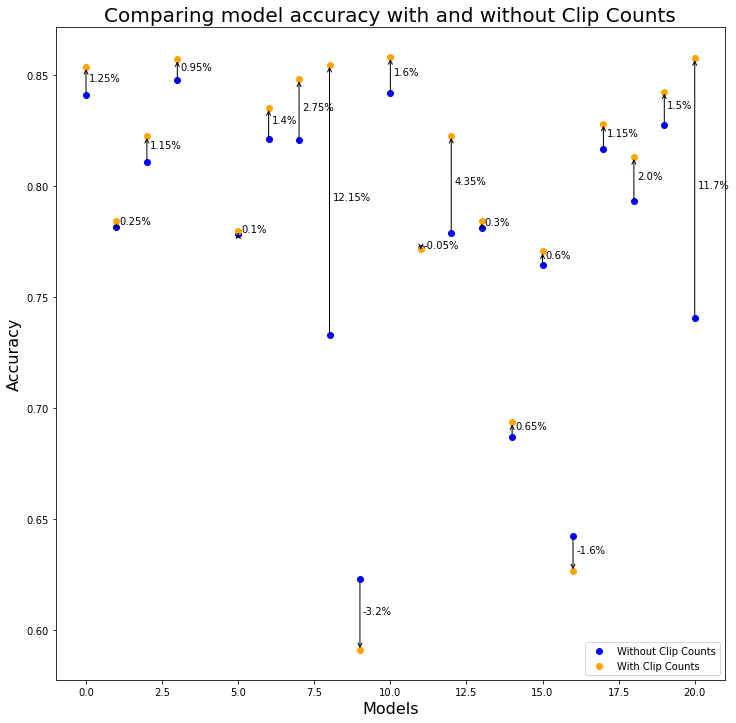

In [20]:
scf.compare_param_plot(all_models, "Clip Counts", False, True)

# -----------------------------------------------------------------------------------------------------------------

# Experiments with the data used to train the models

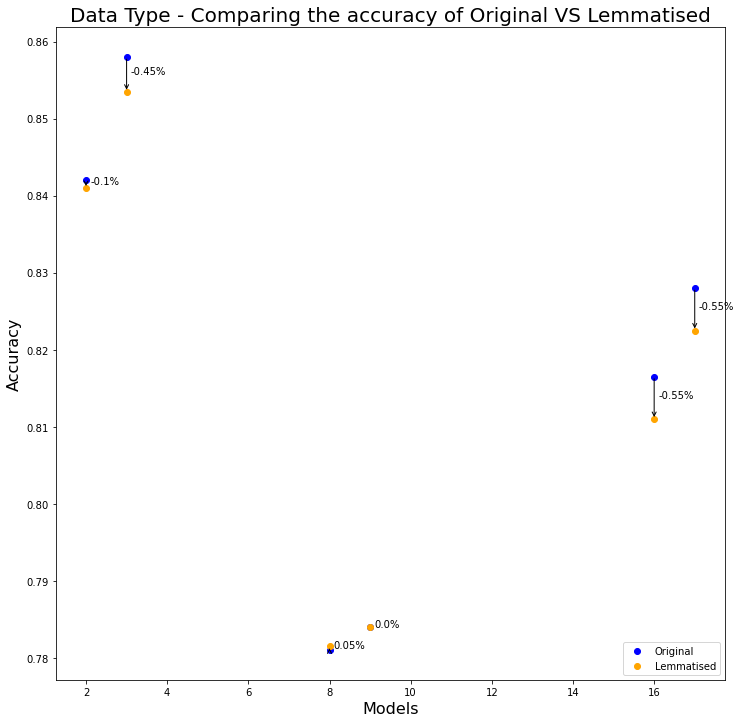

In [25]:
scf.compare_param_plot(all_models, "Data Type", "Original", "Lemmatised")

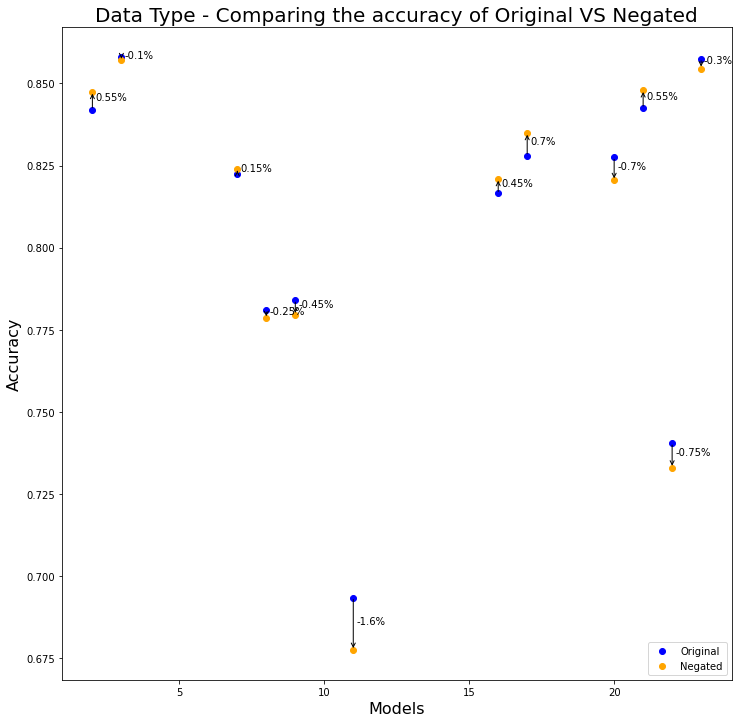

In [24]:
scf.compare_param_plot(all_models, "Data Type", "Original", "Negated")

# -----------------------------------------------------------------------------------------------------------------

# Experiments with different models

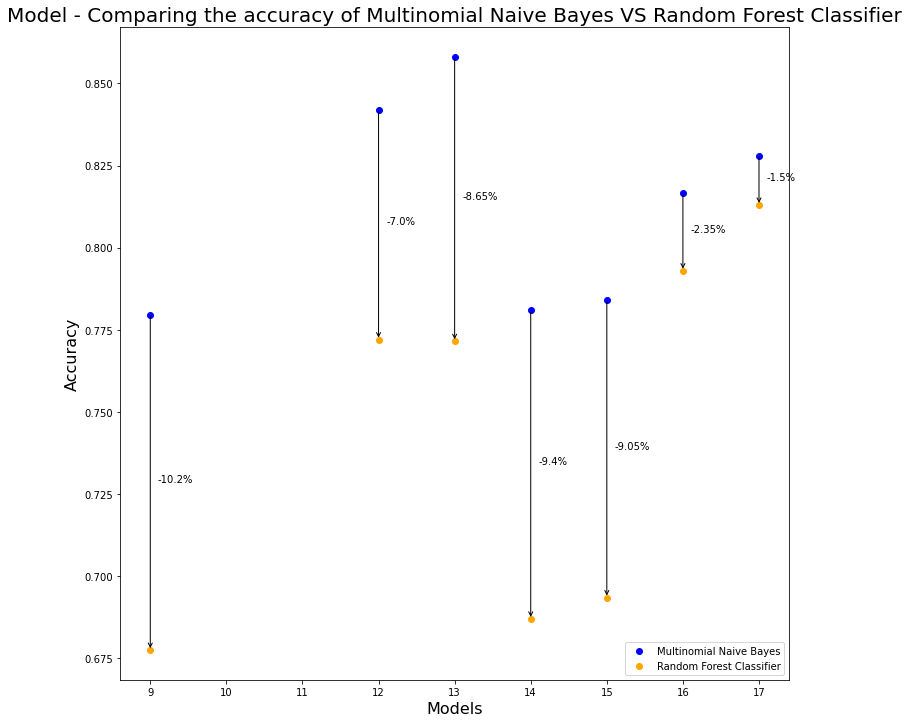

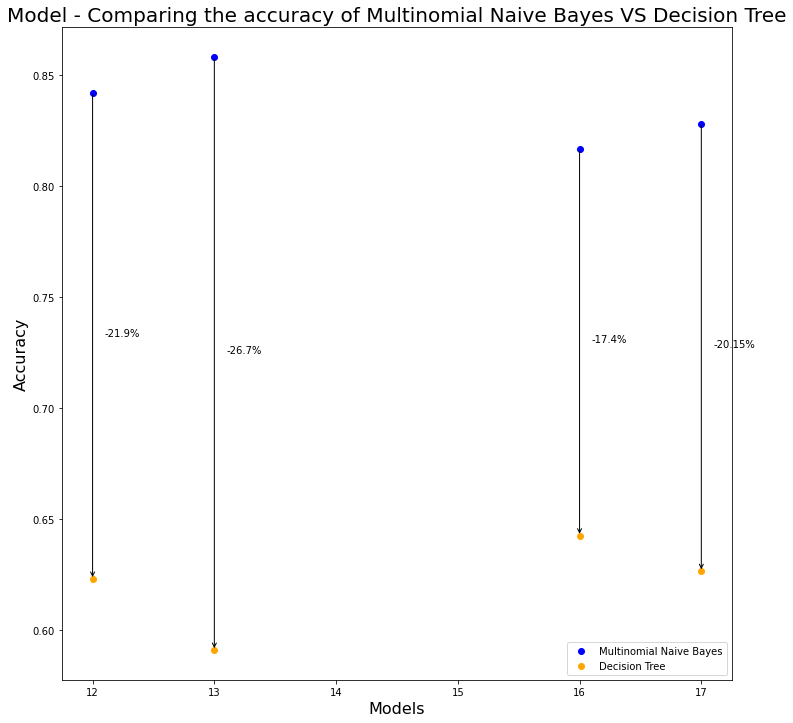

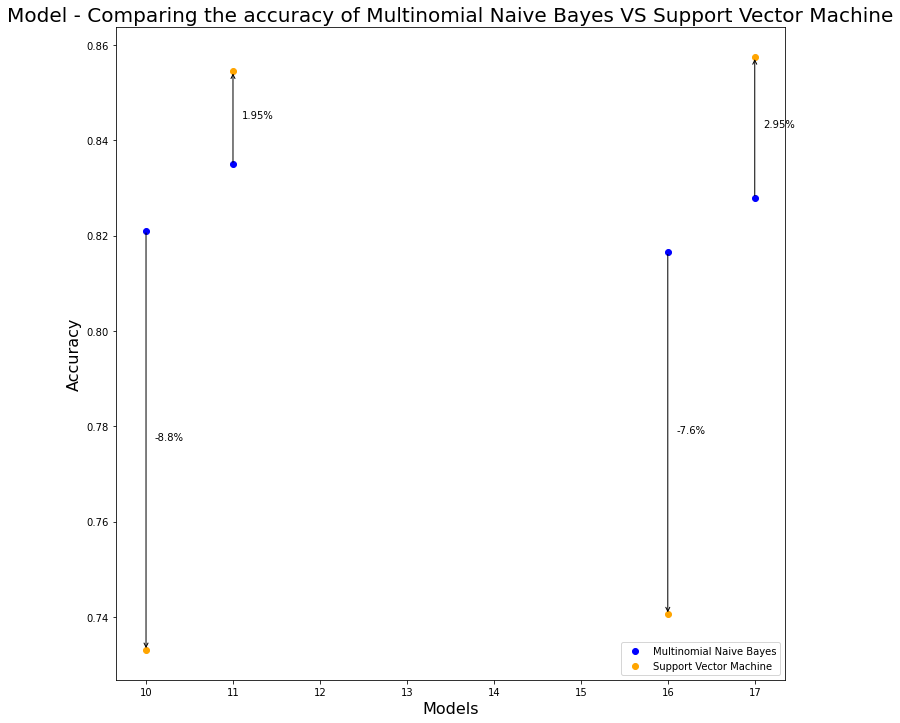

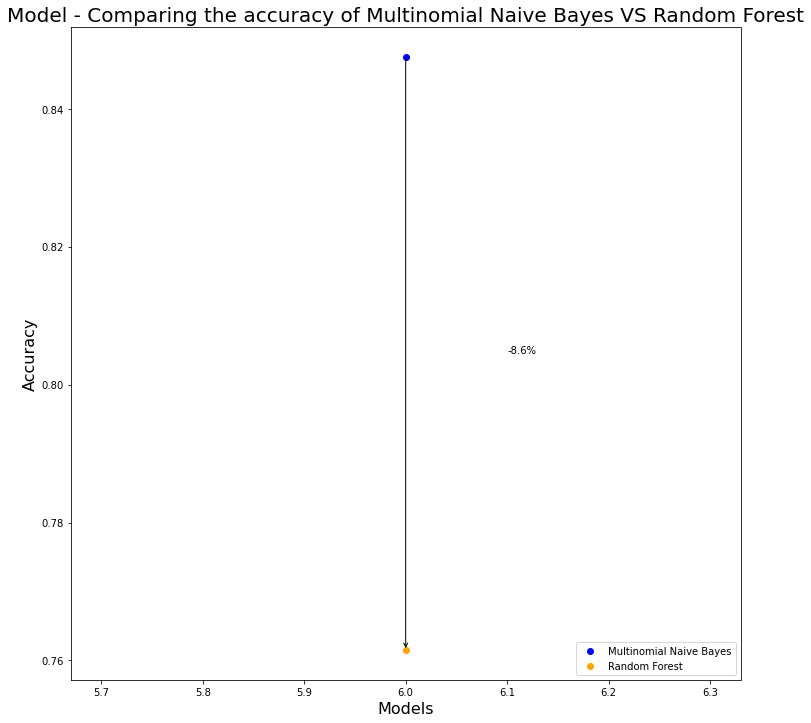

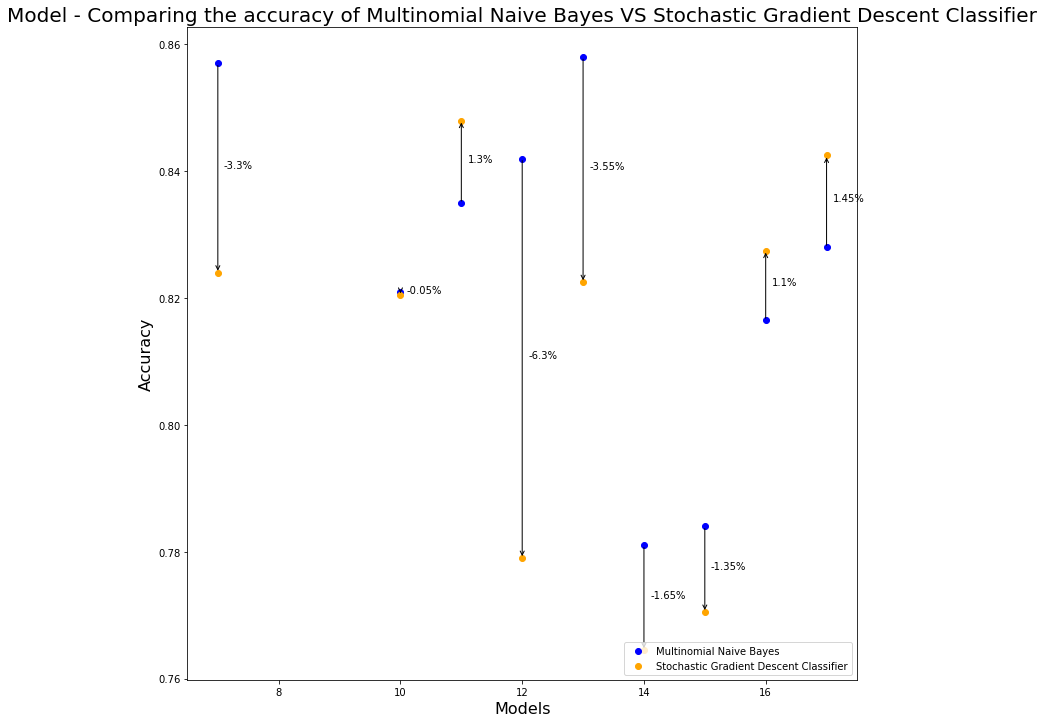

In [26]:
for model_name in set(all_models["Model"]):
    if model_name == "Multinomial Naive Bayes":
        continue
    scf.compare_param_plot(all_models, "Model", "Multinomial Naive Bayes", model_name)

# -----------------------------------------------------------------------------------------------------------------

In [ ]:
break!

# Old Run

In [52]:
eval_df

,Model,Avg Accuracy,Root Mean Squared Error,Min Accuracy,Max Accuracy,Total Time (s),All Fold Averages
0,Lemmatised Unigram Naive Bayes with clip counts,0.8225,0.019780,0.795,0.865,697.71,"[0.8, 0.835, 0.83, 0.81, 0.825, 0.805, 0.825, ..."
1,Non-lemmatised Unigram Naive Bayes with clip c...,0.8270,0.020761,0.785,0.855,34.22,"[0.795, 0.835, 0.84, 0.82, 0.835, 0.825, 0.845..."
2,Lemmatised Unigram Naive Bayes no clip counts,0.8110,0.024372,0.755,0.835,694.20,"[0.78, 0.825, 0.835, 0.82, 0.81, 0.805, 0.835,..."
3,Non-lemmatised Unigram Naive Bayes no clip counts,0.8165,0.028814,0.760,0.850,38.40,"[0.765, 0.85, 0.835, 0.825, 0.815, 0.82, 0.835..."
4,Lemmatised Bigram Naive Bayes with clip counts,0.8535,0.023243,0.805,0.885,843.02,"[0.805, 0.865, 0.84, 0.86, 0.825, 0.85, 0.86, ..."
5,Non-lemmatised Bigram Naive Bayes with clip co...,0.8580,0.022494,0.815,0.885,182.36,"[0.815, 0.88, 0.835, 0.865, 0.83, 0.86, 0.87, ..."
6,Lemmatised Bigram Naive Bayes no clip counts,0.8410,0.028089,0.775,0.870,853.54,"[0.775, 0.86, 0.83, 0.865, 0.81, 0.835, 0.855,..."
7,Non-lemmatised Bigram Naive Bayes no clip counts,0.8420,0.024515,0.800,0.880,187.90,"[0.8, 0.88, 0.82, 0.865, 0.81, 0.835, 0.855, 0..."
8,Lemmatised Trigram Naive Bayes with clip counts,0.7840,0.017000,0.755,0.820,1417.06,"[0.82, 0.795, 0.77, 0.755, 0.78, 0.785, 0.785,..."
9,Non-lemmatised Trigram Naive Bayes with clip c...,0.7840,0.022000,0.750,0.820,755.80,"[0.82, 0.795, 0.765, 0.77, 0.75, 0.795, 0.79, ..."


In [38]:
eval_df

,Model,Accuracy,Stddev,Min,Max,Duration (s)
0,Unigram Naive Bayes with clip_counts,0.8270,0.020761,0.785,0.855,41.099505
1,Unigram Naive Bayes no clip_counts,0.8165,0.028814,0.760,0.850,48.668412
2,Bigram Naive Bayes with clip_counts,0.8580,0.022494,0.815,0.885,229.376951
3,Bigram Naive Bayes no clip_counts,0.8420,0.024515,0.800,0.880,228.880124
4,Trigram Naive Bayes with clip_counts,0.7840,0.022000,0.750,0.820,864.413064
5,Trigram Naive Bayes no clip_counts,0.7810,0.011790,0.760,0.800,779.532211


In [25]:
eval_df

,Model,Accuracy,Stddev,Min,Max,Duration (s)
0,Unigram Support Vector Machine with clip counts,0.8415,0.025695,0.790,0.880,45.02
1,Unigram Support Vector Machine no clip counts,0.8090,0.046087,0.685,0.865,85.20
2,Bigram Support Vector Machine with clip counts,0.8160,0.021772,0.790,0.865,1225.93
3,Bigram Support Vector Machine no clip counts,0.7975,0.020767,0.755,0.830,1121.27


In [18]:
eval_df

,Model,Accuracy,Stddev,Min,Max,Duration (s)
0,Unigram Logistic Regression with clip counts,0.8675,0.019653,0.84,0.91,2538.34


In [72]:
eval_df

,Model,Duration (s),Accuracy,Root MSE,Min,Max
0,Unigram Random Forest with clip counts,136.48,0.820,0.030984,0.775,0.875
1,Unigram Random Forest no clip counts,138.66,0.787,0.021703,0.750,0.830
